In [1]:
freq = 15

In [2]:
paciente='paciente1'

In [3]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [4]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [7]:
len(array_Xtest)

191

In [8]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [9]:
len(array_Ytest)

191

# Pruebas Vanilla LSTM con dropout

In [10]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_dropout.h5')

In [11]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [12]:
len(array_Ytest)

191

6/6 [==============================] - 0s 6ms/step


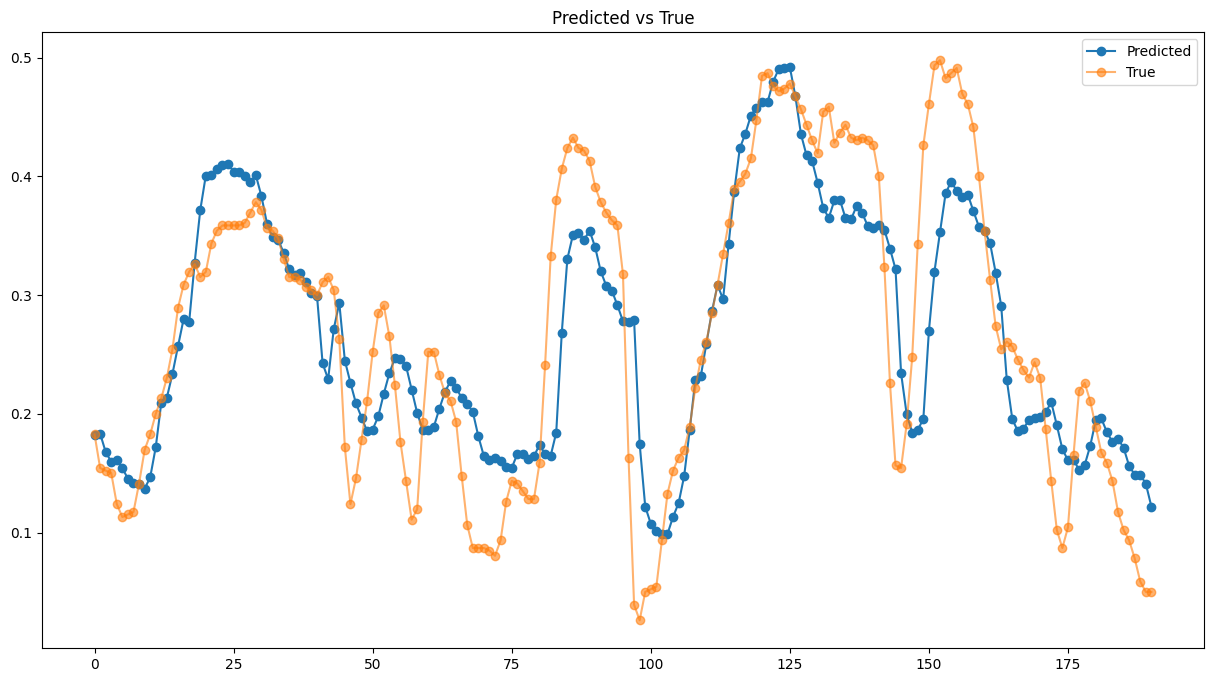

In [13]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [14]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.05179051807298222,
 'mse': 0.06756006406011335,
 'rmse': 0.00456436225580662}

In [15]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       123.834496
1       124.325966
2       117.211502
3       113.399734
4       114.083321
..             ...
186     111.830383
187     108.433594
188     108.442360
189     104.897202
190      96.084854

[191 rows x 1 columns]

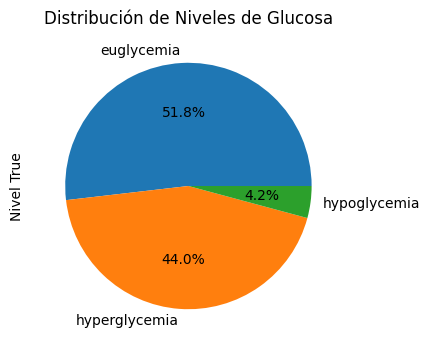

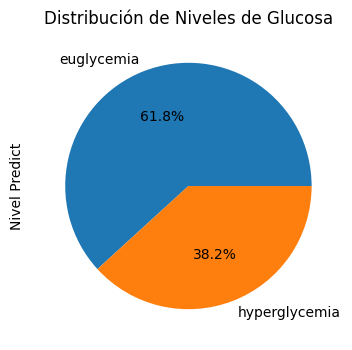

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             123.834496    euglycemia
1               111.0  euglycemia             124.325966    euglycemia
2               110.0  euglycemia             117.211502    euglycemia
3               109.0  euglycemia             113.399734    euglycemia
4                97.0  euglycemia             114.083321    euglycemia

In [16]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


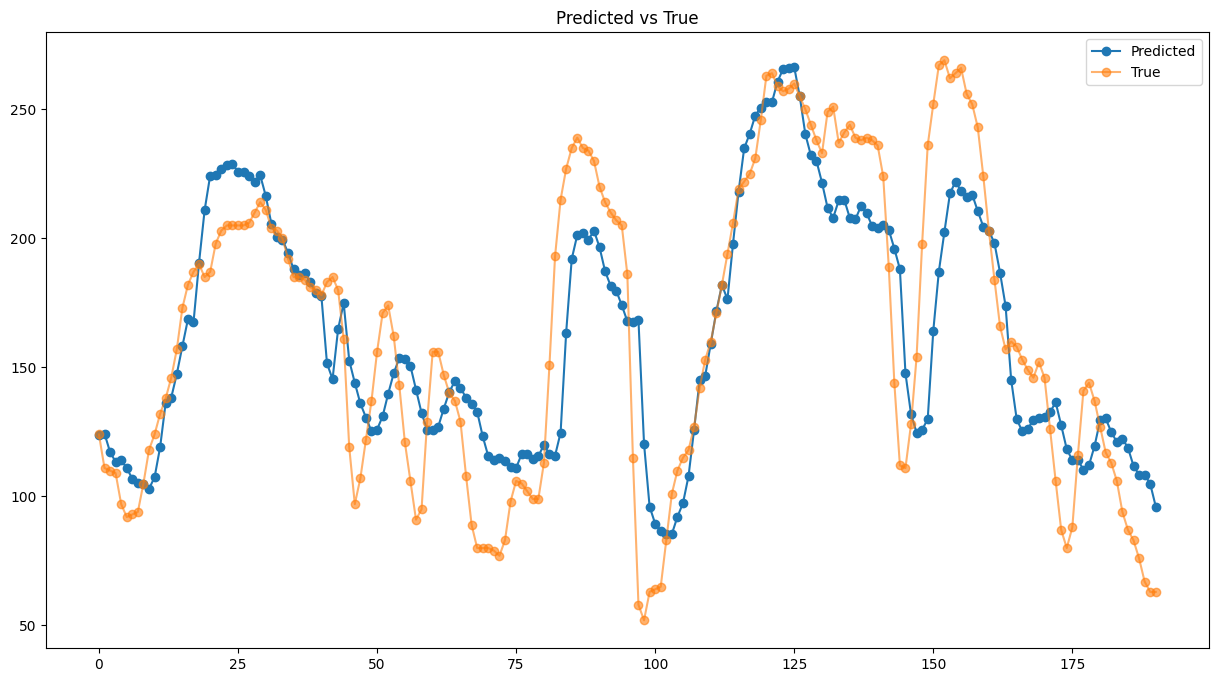

{'mae': 23.823637318236667,
 'mse': 31.07762834801507,
 'rmse': 965.8189837373501}

In [17]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [18]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [19]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  123.834496
2023-01-01 00:15:00   111.0  124.325966
2023-01-01 00:30:00   110.0  117.211502
2023-01-01 00:45:00   109.0  113.399734
2023-01-01 01:00:00    97.0  114.083321
...                     ...         ...
2023-01-02 22:30:00    83.0  111.830383
2023-01-02 22:45:00    76.0  108.433594
2023-01-02 23:00:00    67.0  108.442360
2023-01-02 23:15:00    63.0  104.897202
2023-01-02 23:30:00    63.0   96.084854

[191 rows x 2 columns]

AP, BE, EP: (0.8842105263157894, 0.06315789473684211, 0.05263157894736842)


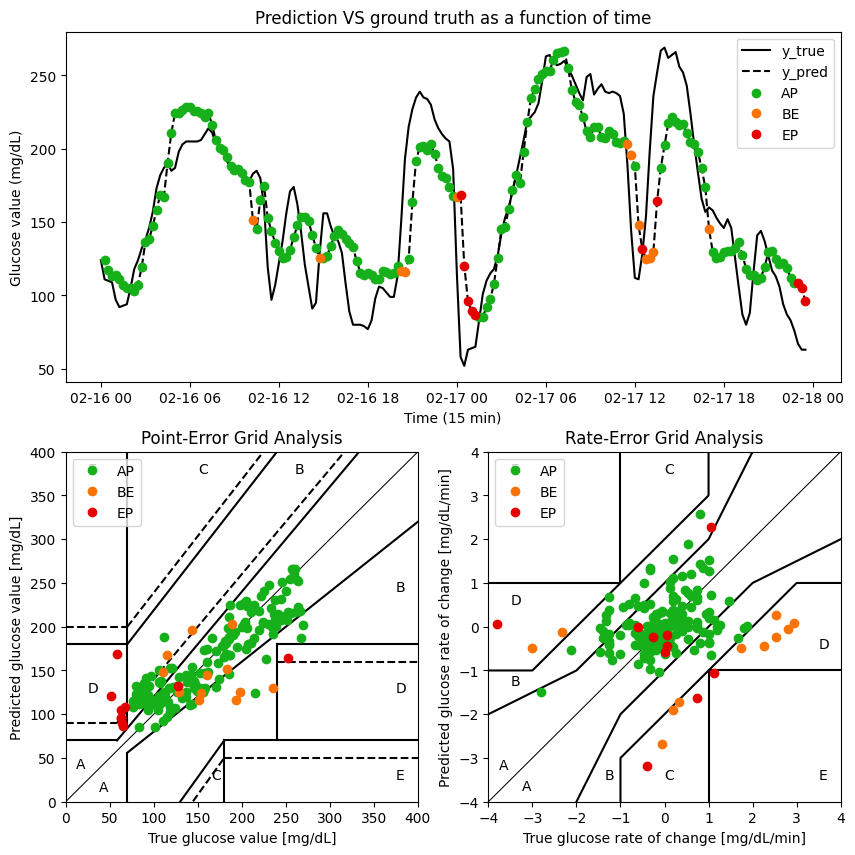

In [20]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [21]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-16 00:00:00   124.0  123.834496       NaN       NaN    NaN   NaN   
1   2023-02-16 00:15:00   111.0  124.325966 -0.866667  0.032765     AP     A   
2   2023-02-16 00:30:00   110.0  117.211502 -0.066667 -0.474298     AP     A   
3   2023-02-16 00:45:00   109.0  113.399734 -0.066667 -0.254118     AP     A   
4   2023-02-16 01:00:00    97.0  114.083321 -0.800000  0.045572     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-17 22:30:00    83.0  111.830383 -0.266667 -0.468827     AP     B   
187 2023-02-17 22:45:00    76.0  108.433594 -0.466667 -0.226453     AP     B   
188 2023-02-17 23:00:00    67.0  108.442360 -0.600000  0.000584     EP     D   
189 2023-02-17 23:15:00    63.0  104.897202 -0.266667 -0.236344     EP     D   
190 2023-02-17 23:30:00    63.0   96.084854  0.000000 -0.587490     EP     D   

    R_EGA  
0     NaN  
1       A  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [22]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [23]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 29ms/step


Glucose level Predict  Glucose level True
0               0.182249            0.182609
1               0.183317            0.154348

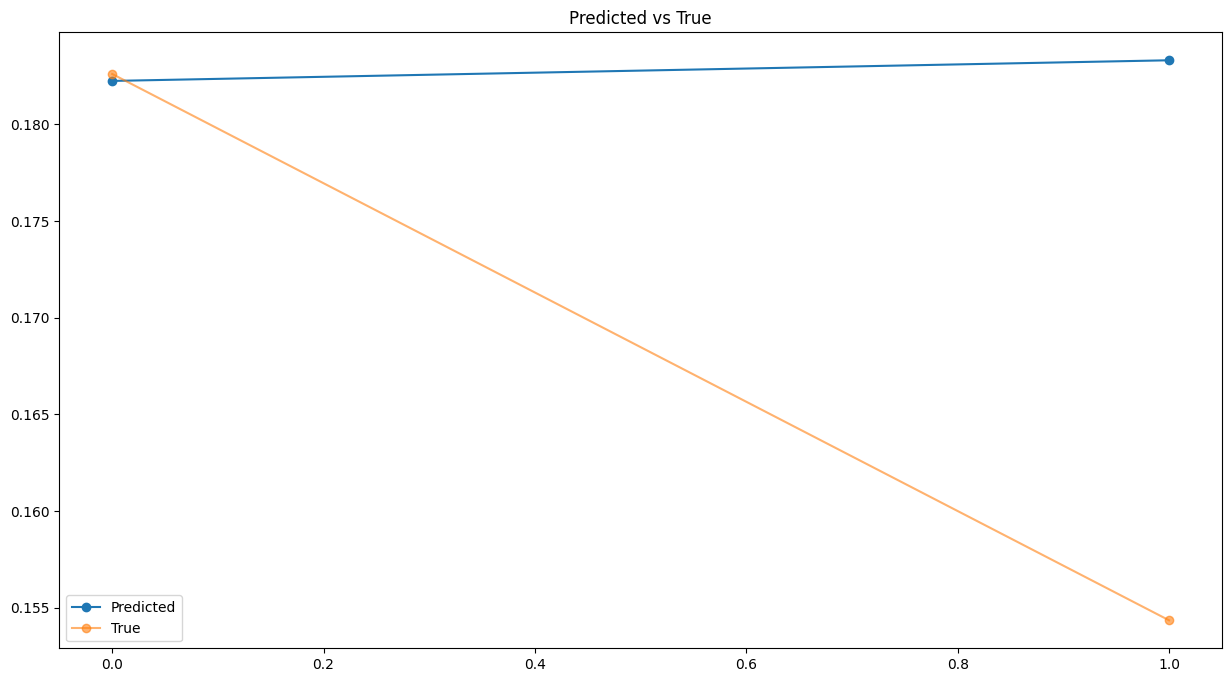

{'mae': 0.01466465631256933,
 'mse': 0.020486104615235996,
 'rmse': 0.0004196804823063935}

In [24]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [25]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             123.834480               124.0
1             124.325966               111.0

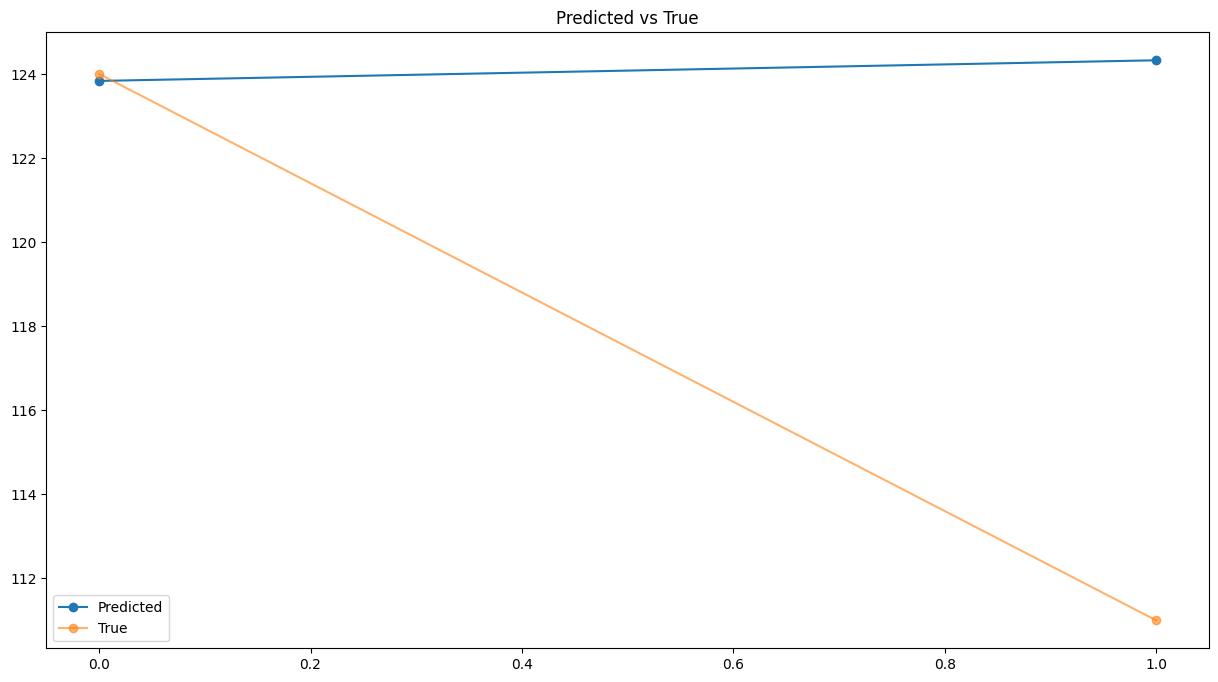

{'mae': 6.7457427978515625, 'mse': 9.42360768089064, 'rmse': 88.80438172334107}

In [26]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Vanilla LSTM sin dropout

In [27]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_NO_dropout.h5')

In [28]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [29]:
len(array_Ytest)

191

6/6 [==============================] - 0s 5ms/step


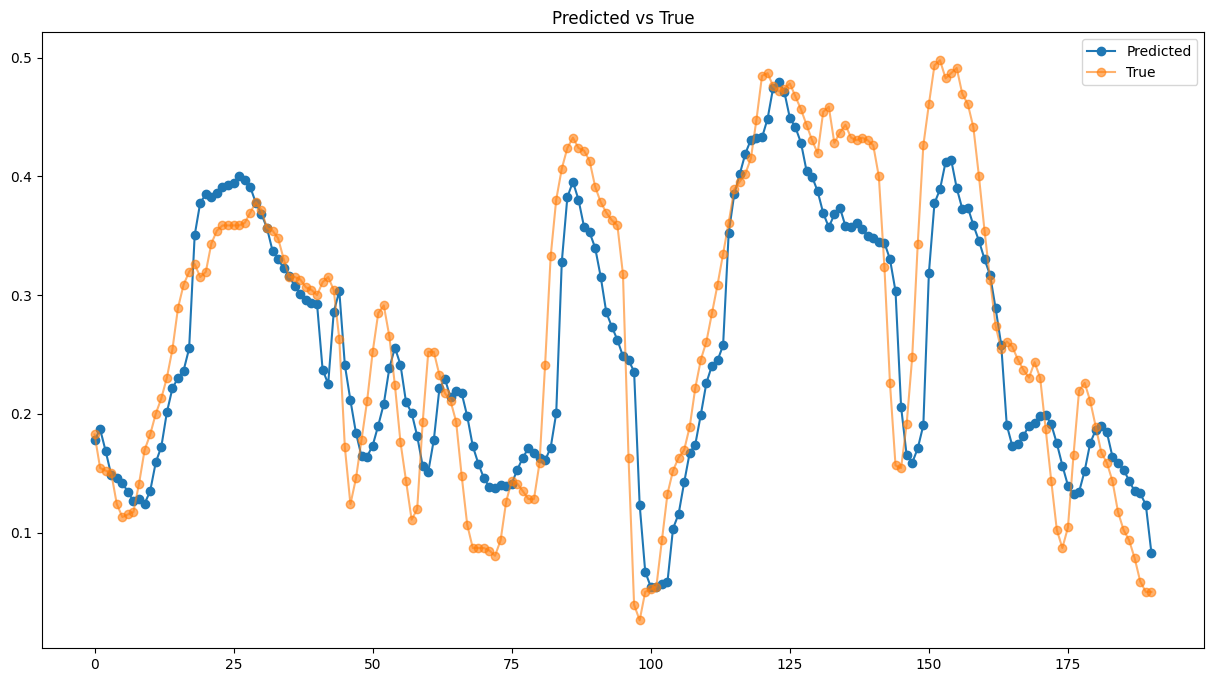

In [30]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.05033851232394091,
 'mse': 0.063184599960452,
 'rmse': 0.003992293672162352}

In [32]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       121.727219
1       126.042023
2       117.524597
3       108.285072
4       107.229294
..             ...
186     106.105667
187     101.983963
188     101.165367
189      96.751617
190      78.182808

[191 rows x 1 columns]

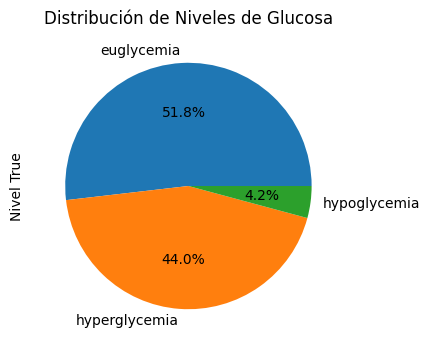

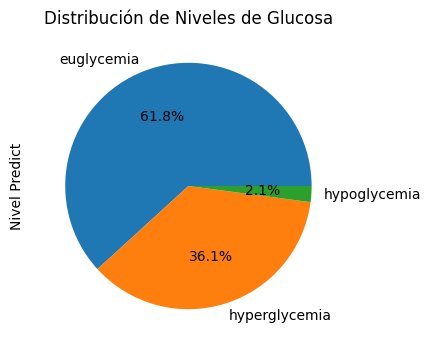

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             121.727219    euglycemia
1               111.0  euglycemia             126.042023    euglycemia
2               110.0  euglycemia             117.524597    euglycemia
3               109.0  euglycemia             108.285072    euglycemia
4                97.0  euglycemia             107.229294    euglycemia

In [33]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


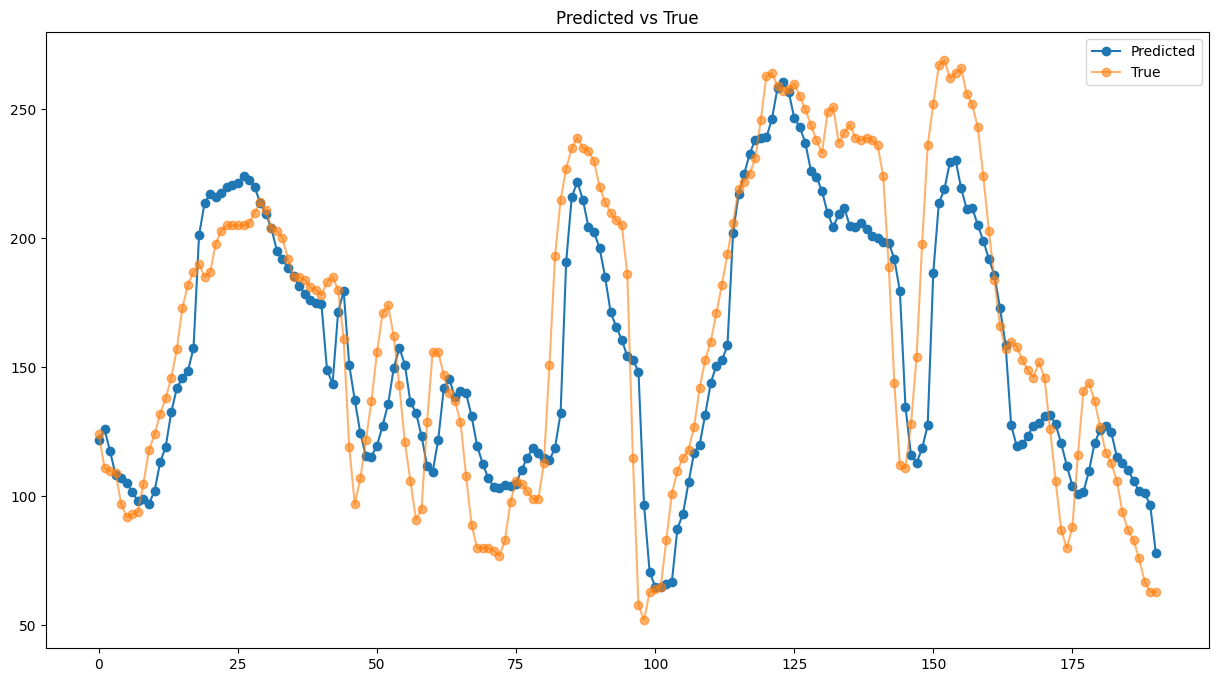

{'mae': 23.155714384548325,
 'mse': 29.064915103671094,
 'rmse': 844.769289983608}

In [34]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [35]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [36]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  121.727219
2023-01-01 00:15:00   111.0  126.042023
2023-01-01 00:30:00   110.0  117.524597
2023-01-01 00:45:00   109.0  108.285072
2023-01-01 01:00:00    97.0  107.229294
...                     ...         ...
2023-01-02 22:30:00    83.0  106.105667
2023-01-02 22:45:00    76.0  101.983963
2023-01-02 23:00:00    67.0  101.165367
2023-01-02 23:15:00    63.0   96.751617
2023-01-02 23:30:00    63.0   78.182808

[191 rows x 2 columns]

AP, BE, EP: (0.8842105263157894, 0.08421052631578947, 0.031578947368421054)


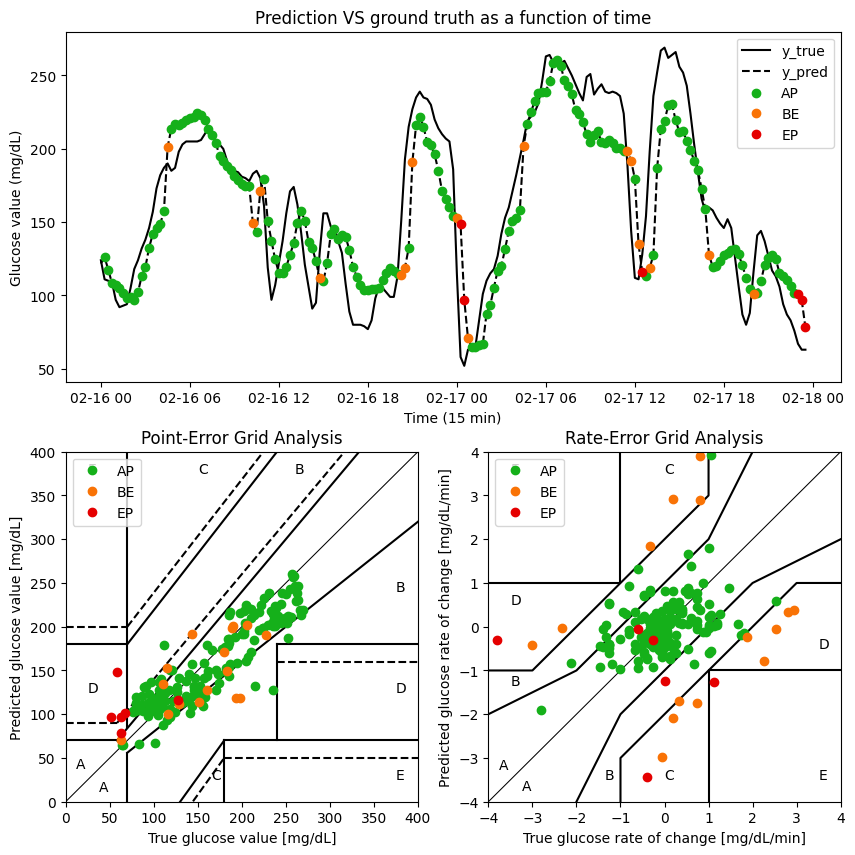

In [37]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [38]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-16 00:00:00   124.0  121.727219       NaN       NaN    NaN   NaN   
1   2023-02-16 00:15:00   111.0  126.042023 -0.866667  0.287654     AP     A   
2   2023-02-16 00:30:00   110.0  117.524597 -0.066667 -0.567828     AP     A   
3   2023-02-16 00:45:00   109.0  108.285072 -0.066667 -0.615968     AP     A   
4   2023-02-16 01:00:00    97.0  107.229294 -0.800000 -0.070385     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-17 22:30:00    83.0  106.105667 -0.266667 -0.282182     AP     B   
187 2023-02-17 22:45:00    76.0  101.983963 -0.466667 -0.274780     AP     B   
188 2023-02-17 23:00:00    67.0  101.165367 -0.600000 -0.054573     EP     D   
189 2023-02-17 23:15:00    63.0   96.751617 -0.266667 -0.294250     EP     D   
190 2023-02-17 23:30:00    63.0   78.182808  0.000000 -1.237921     EP     D   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     B  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [39]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [40]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 28ms/step


Glucose level Predict  Glucose level True
0               0.177668            0.182609
1               0.187048            0.154348

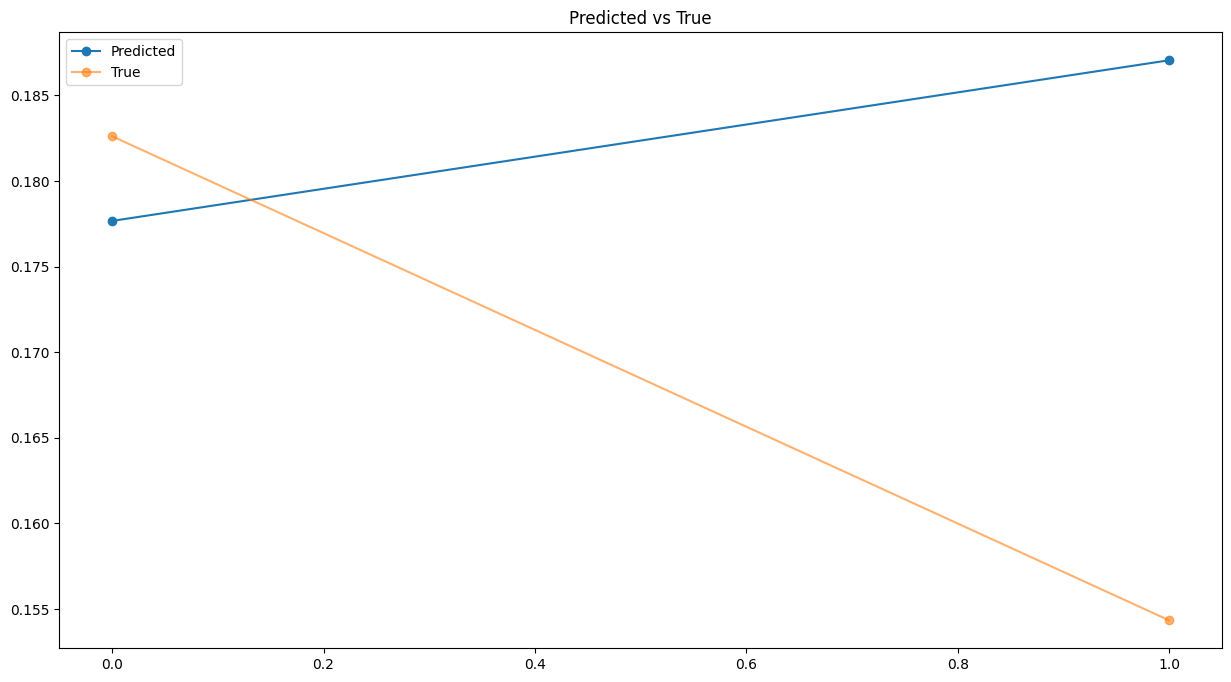

{'mae': 0.0188204486085021,
 'mse': 0.023384893633681753,
 'rmse': 0.0005468532502586094}

In [41]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [42]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             121.727219               124.0
1             126.042038               111.0

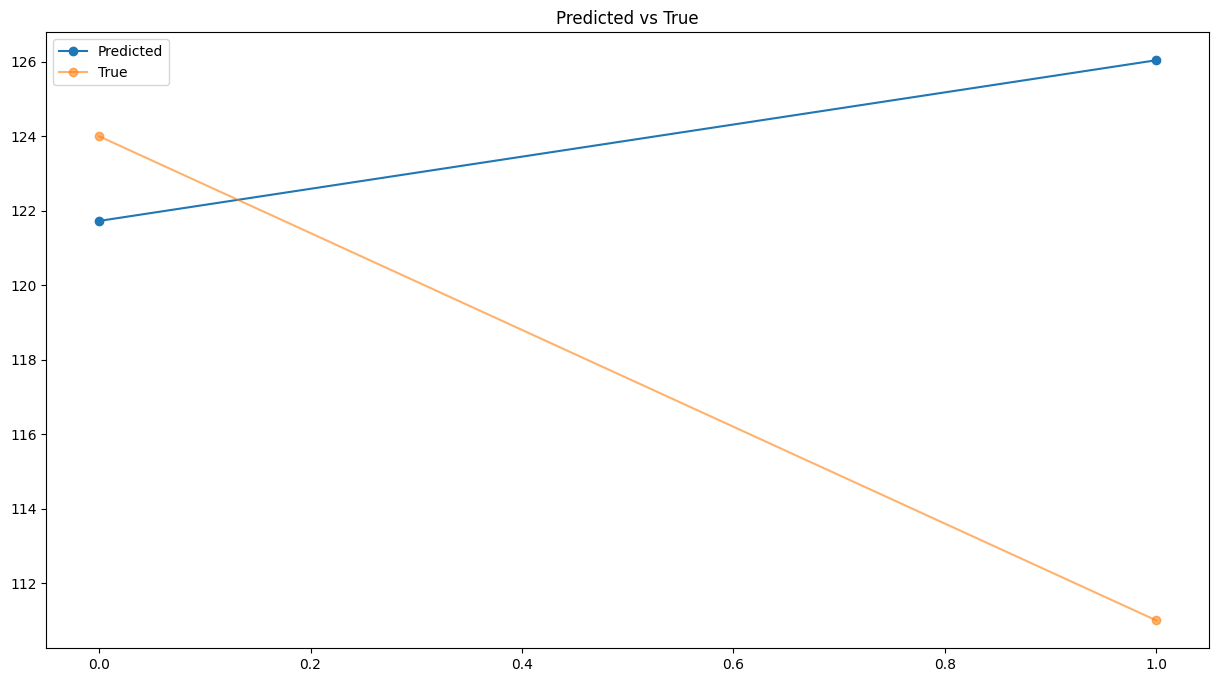

{'mae': 8.65740966796875,
 'mse': 10.757054459089893,
 'rmse': 115.71422063582577}

In [43]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM con dropout

In [44]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_dropout.h5')

In [45]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [46]:
len(array_Ytest)

191

6/6 [==============================] - 1s 12ms/step


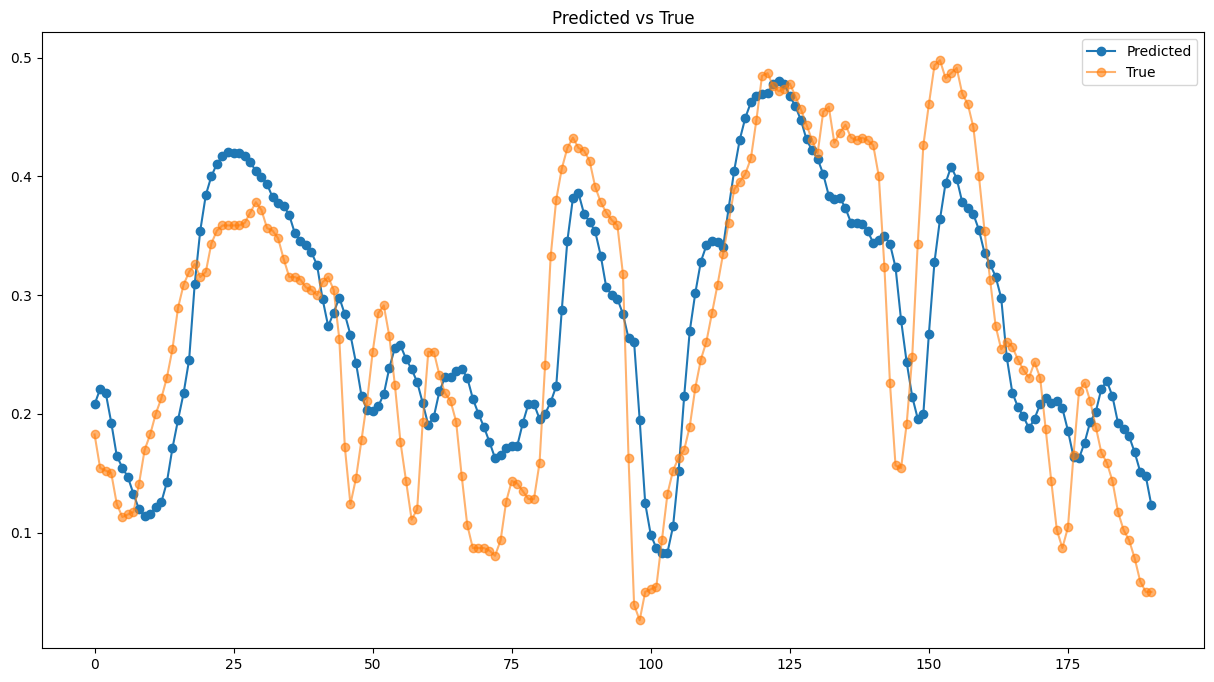

In [47]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [48]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.060287035640770925,
 'mse': 0.07264134948460227,
 'rmse': 0.005276765654944126}

In [49]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       135.618286
1       141.651459
2       140.183090
3       128.611588
4       115.598976
..             ...
186     123.271629
187     117.053223
188     109.524467
189     107.778152
190      96.525253

[191 rows x 1 columns]

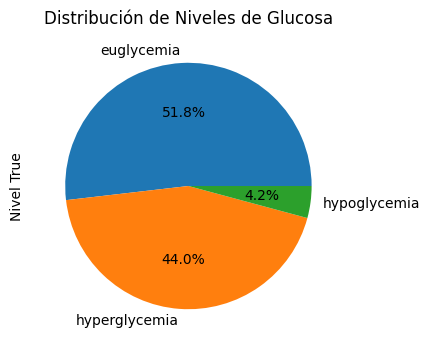

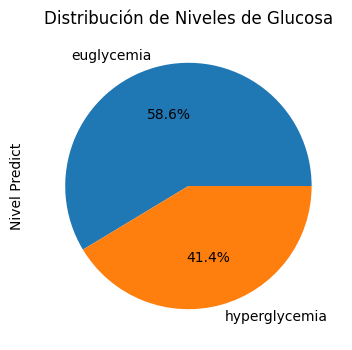

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             135.618286    euglycemia
1               111.0  euglycemia             141.651459    euglycemia
2               110.0  euglycemia             140.183090    euglycemia
3               109.0  euglycemia             128.611588    euglycemia
4                97.0  euglycemia             115.598976    euglycemia

In [50]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


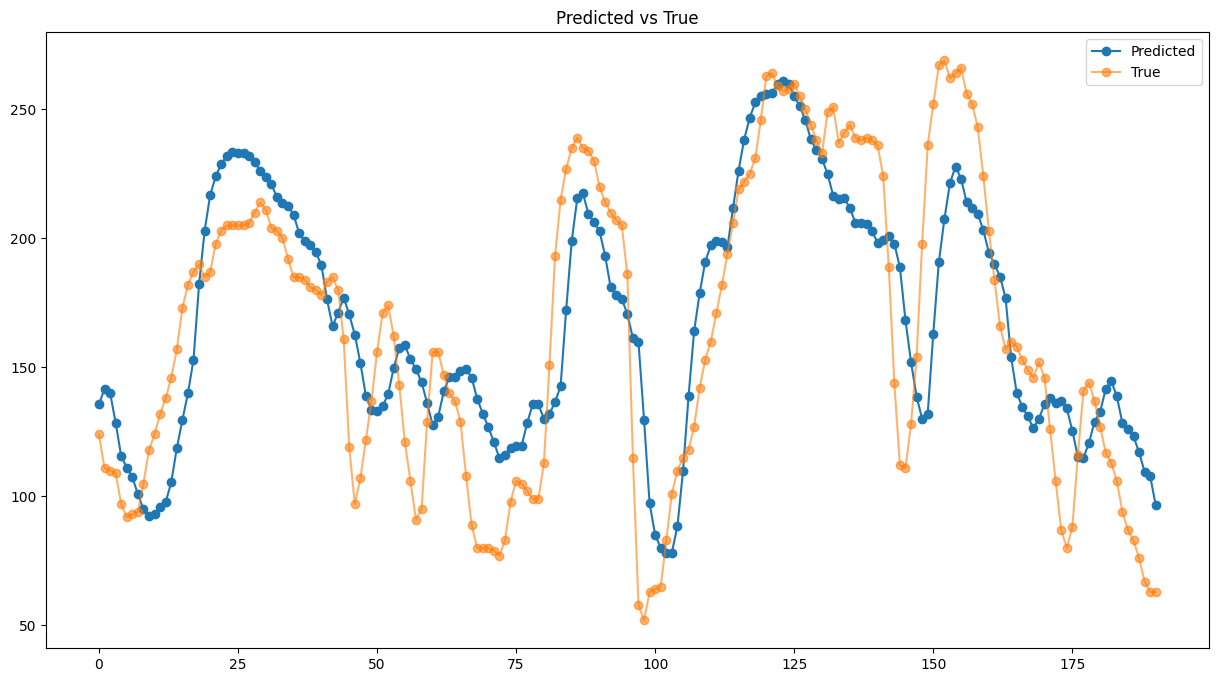

{'mae': 27.732036890159726,
 'mse': 33.415020894594846,
 'rmse': 1116.5636213862103}

In [51]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [52]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [53]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  135.618286
2023-01-01 00:15:00   111.0  141.651459
2023-01-01 00:30:00   110.0  140.183090
2023-01-01 00:45:00   109.0  128.611588
2023-01-01 01:00:00    97.0  115.598976
...                     ...         ...
2023-01-02 22:30:00    83.0  123.271629
2023-01-02 22:45:00    76.0  117.053223
2023-01-02 23:00:00    67.0  109.524467
2023-01-02 23:15:00    63.0  107.778152
2023-01-02 23:30:00    63.0   96.525253

[191 rows x 2 columns]

AP, BE, EP: (0.8842105263157894, 0.06315789473684211, 0.05263157894736842)


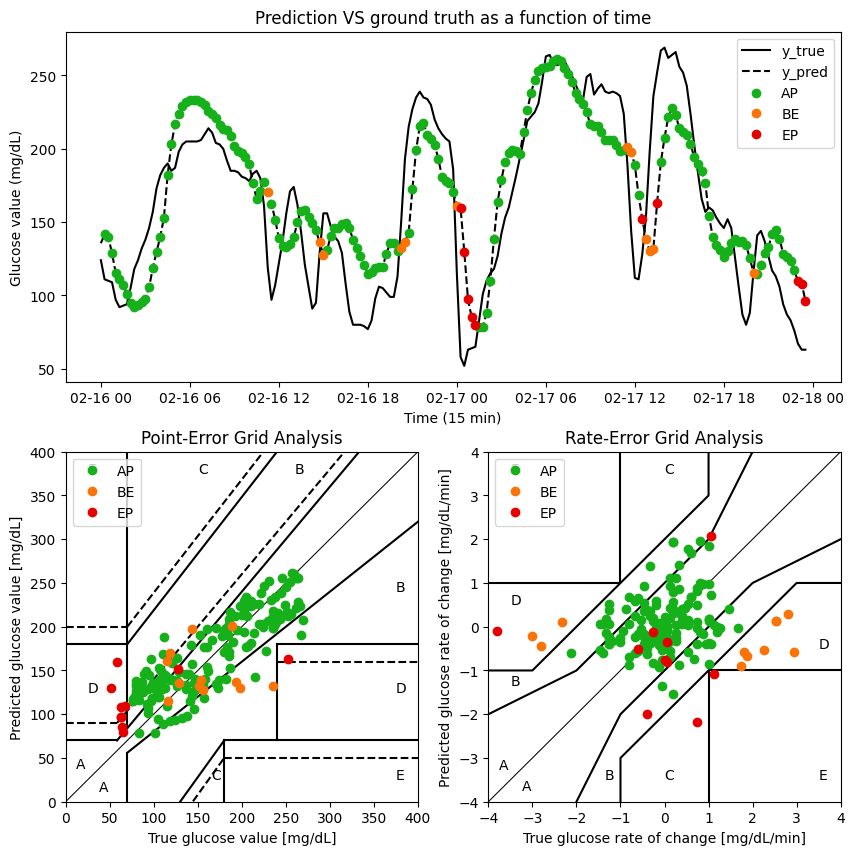

In [54]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [55]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-16 00:00:00   124.0  135.618286       NaN       NaN    NaN   NaN   
1   2023-02-16 00:15:00   111.0  141.651459 -0.866667  0.402212     AP     B   
2   2023-02-16 00:30:00   110.0  140.183090 -0.066667 -0.097891     AP     B   
3   2023-02-16 00:45:00   109.0  128.611588 -0.066667 -0.771434     AP     A   
4   2023-02-16 01:00:00    97.0  115.598976 -0.800000 -0.867507     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-17 22:30:00    83.0  123.271629 -0.266667 -0.180975     AP     B   
187 2023-02-17 22:45:00    76.0  117.053223 -0.466667 -0.414560     AP     B   
188 2023-02-17 23:00:00    67.0  109.524467 -0.600000 -0.501917     EP     D   
189 2023-02-17 23:15:00    63.0  107.778152 -0.266667 -0.116421     EP     D   
190 2023-02-17 23:30:00    63.0   96.525253  0.000000 -0.750193     EP     D   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [56]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [57]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 35ms/step


Glucose level Predict  Glucose level True
0               0.207866            0.182609
1               0.220981            0.154348

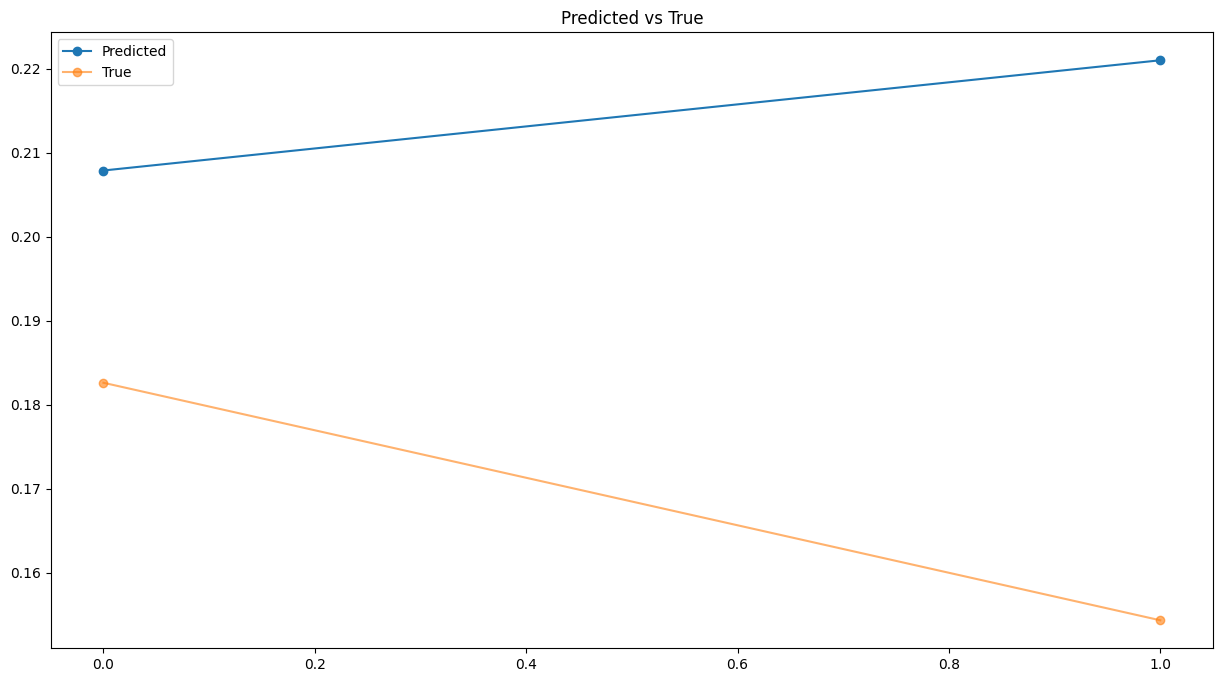

{'mae': 0.045945335989413055,
 'mse': 0.05038827122749357,
 'rmse': 0.0025389778772954568}

In [58]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [59]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             135.618256               124.0
1             141.651459               111.0

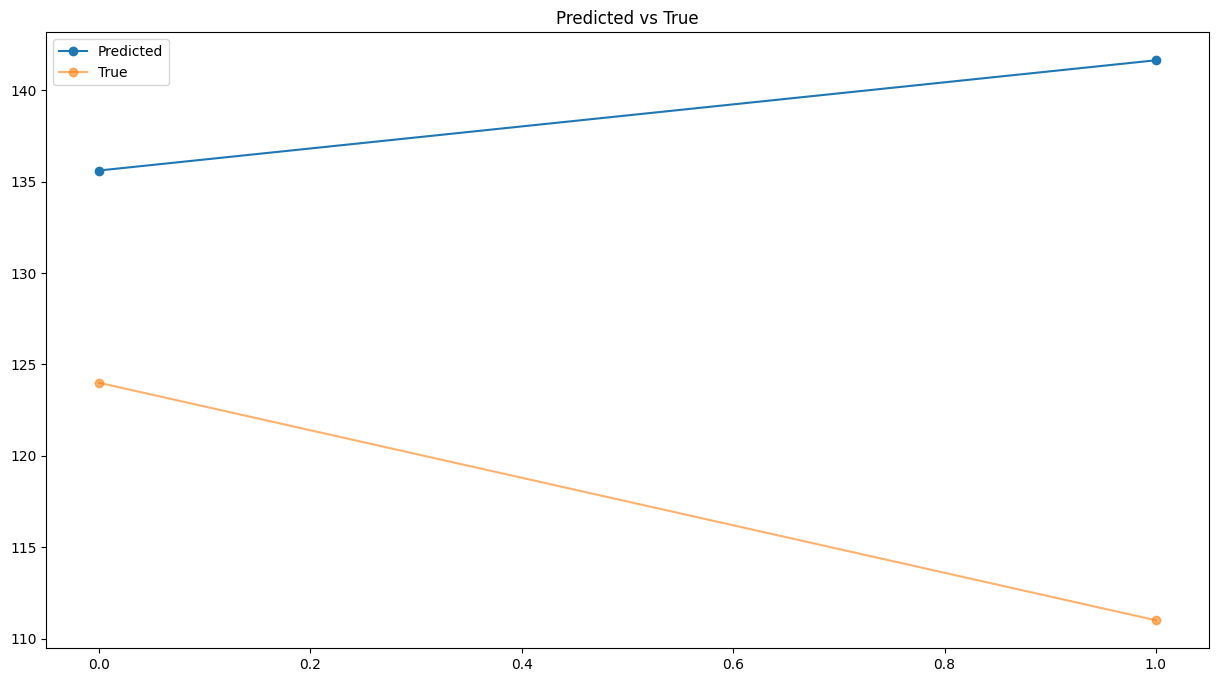

{'mae': 21.134857177734375,
 'mse': 23.178608526454035,
 'rmse': 537.2478932226077}

In [60]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM sin dropout

In [61]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_NO_dropout.h5')

In [62]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [63]:
len(array_Ytest)

191

6/6 [==============================] - 0s 8ms/step


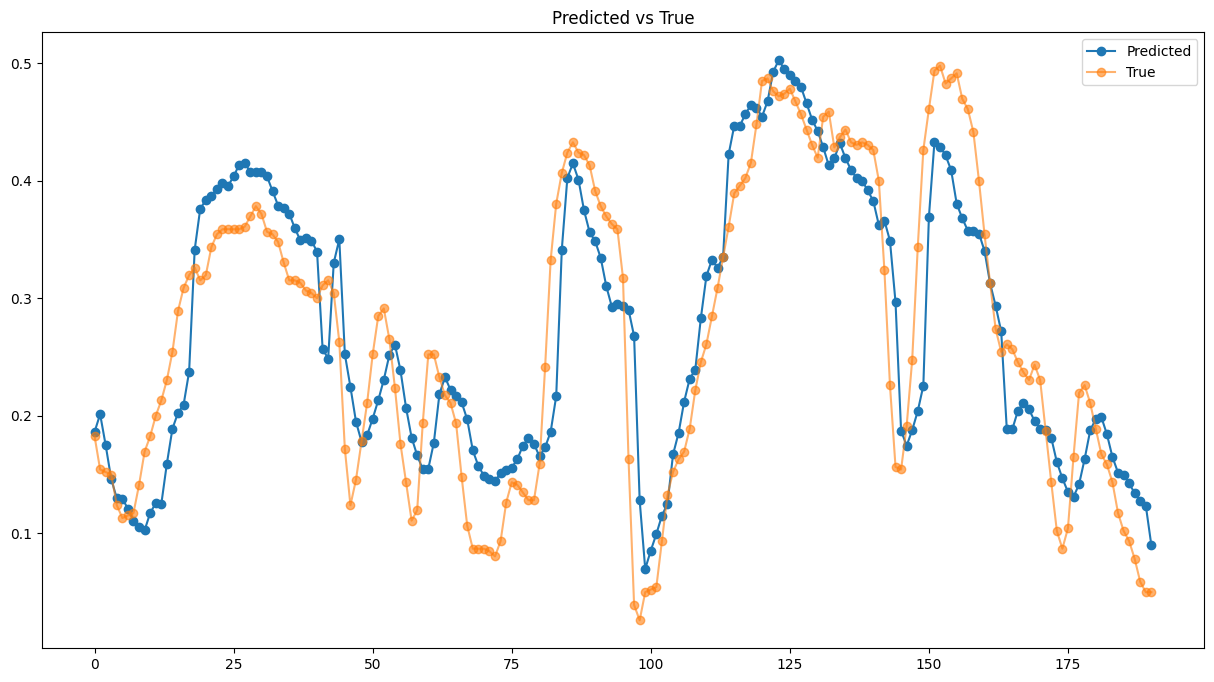

In [64]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [65]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04844459132625279,
 'mse': 0.059324493929218194,
 'rmse': 0.0035193955799578468}

In [66]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       125.696922
1       132.632767
2       120.457016
3       107.219948
4        99.679749
..             ...
186     105.577080
187     101.714806
188      98.707687
189      96.797501
190      81.292015

[191 rows x 1 columns]

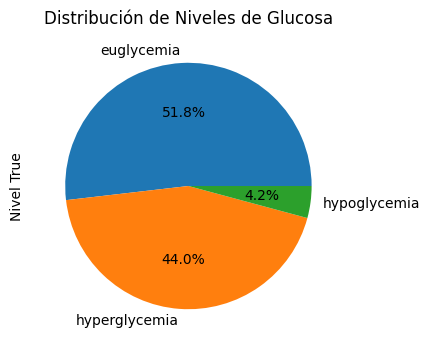

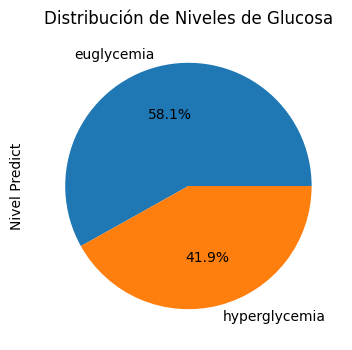

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             125.696922    euglycemia
1               111.0  euglycemia             132.632767    euglycemia
2               110.0  euglycemia             120.457016    euglycemia
3               109.0  euglycemia             107.219948    euglycemia
4                97.0  euglycemia              99.679749    euglycemia

In [67]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


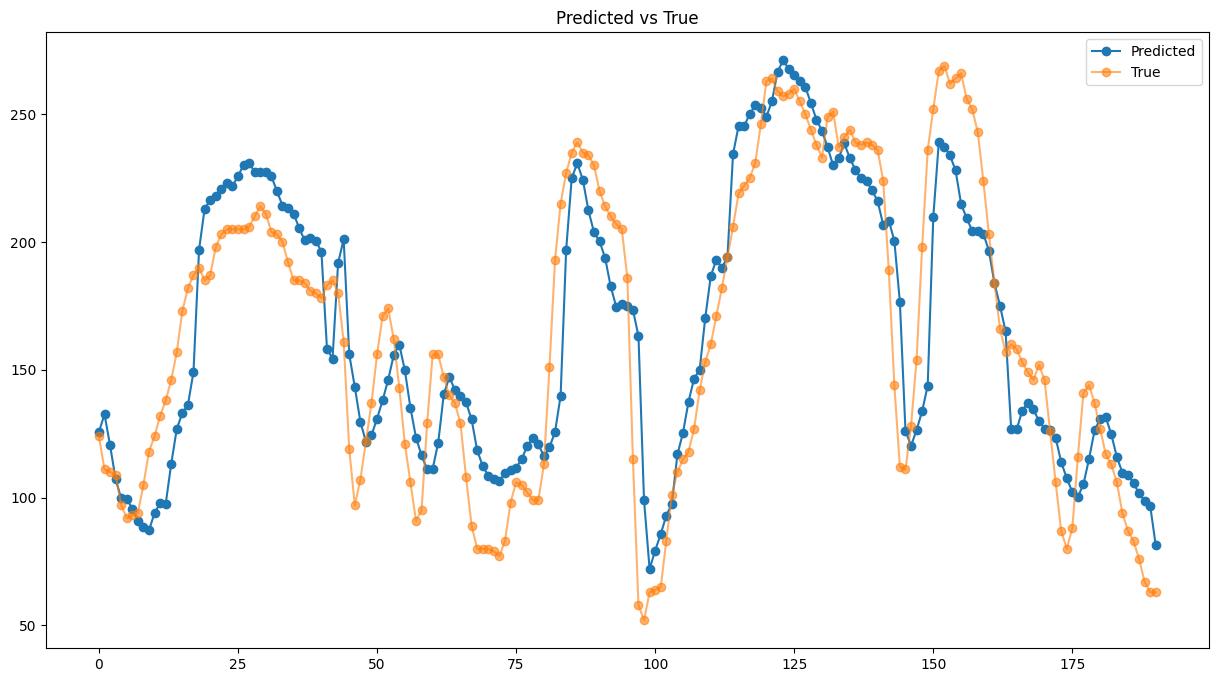

{'mae': 22.284511785856715,
 'mse': 27.289266954139734,
 'rmse': 744.7040908943029}

In [68]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [69]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [70]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  125.696922
2023-01-01 00:15:00   111.0  132.632767
2023-01-01 00:30:00   110.0  120.457016
2023-01-01 00:45:00   109.0  107.219948
2023-01-01 01:00:00    97.0   99.679749
...                     ...         ...
2023-01-02 22:30:00    83.0  105.577080
2023-01-02 22:45:00    76.0  101.714806
2023-01-02 23:00:00    67.0   98.707687
2023-01-02 23:15:00    63.0   96.797501
2023-01-02 23:30:00    63.0   81.292015

[191 rows x 2 columns]

AP, BE, EP: (0.8894736842105263, 0.07368421052631578, 0.03684210526315789)


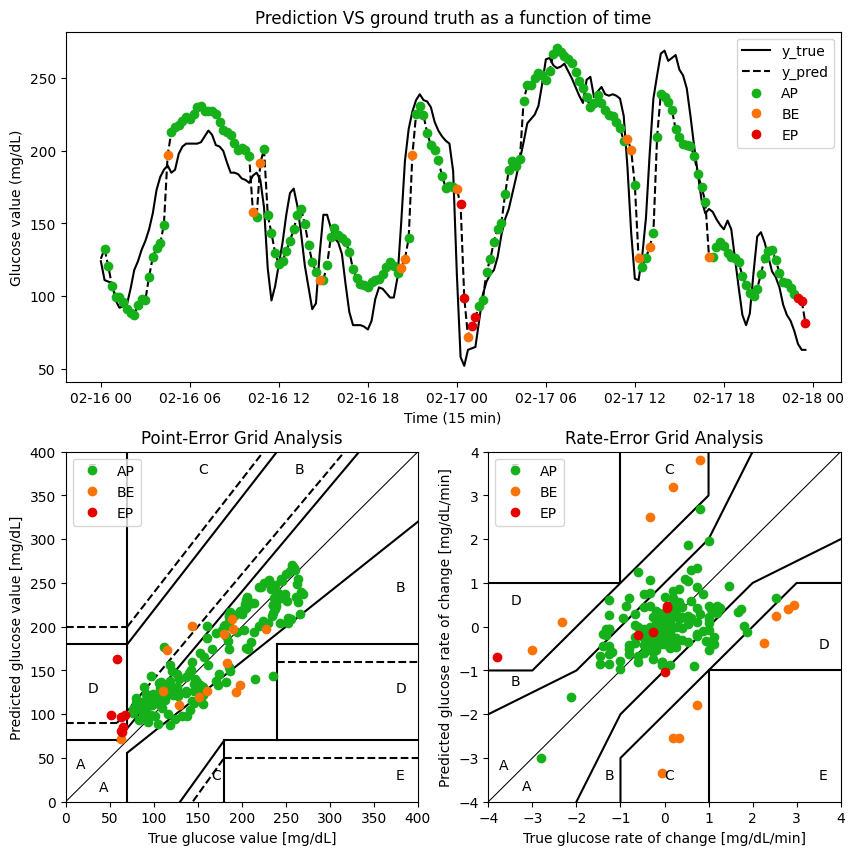

In [71]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [72]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-16 00:00:00   124.0  125.696922       NaN       NaN    NaN   NaN   
1   2023-02-16 00:15:00   111.0  132.632767 -0.866667  0.462390     AP     A   
2   2023-02-16 00:30:00   110.0  120.457016 -0.066667 -0.811717     AP     A   
3   2023-02-16 00:45:00   109.0  107.219948 -0.066667 -0.882471     AP     A   
4   2023-02-16 01:00:00    97.0   99.679749 -0.800000 -0.502680     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-17 22:30:00    83.0  105.577080 -0.266667 -0.229403     AP     B   
187 2023-02-17 22:45:00    76.0  101.714806 -0.466667 -0.257485     AP     B   
188 2023-02-17 23:00:00    67.0   98.707687 -0.600000 -0.200475     EP     D   
189 2023-02-17 23:15:00    63.0   96.797501 -0.266667 -0.127346     EP     D   
190 2023-02-17 23:30:00    63.0   81.292015  0.000000 -1.033699     EP     D   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     B  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [73]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [74]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 34ms/step


Glucose level Predict  Glucose level True
0               0.186298            0.182609
1               0.201376            0.154348

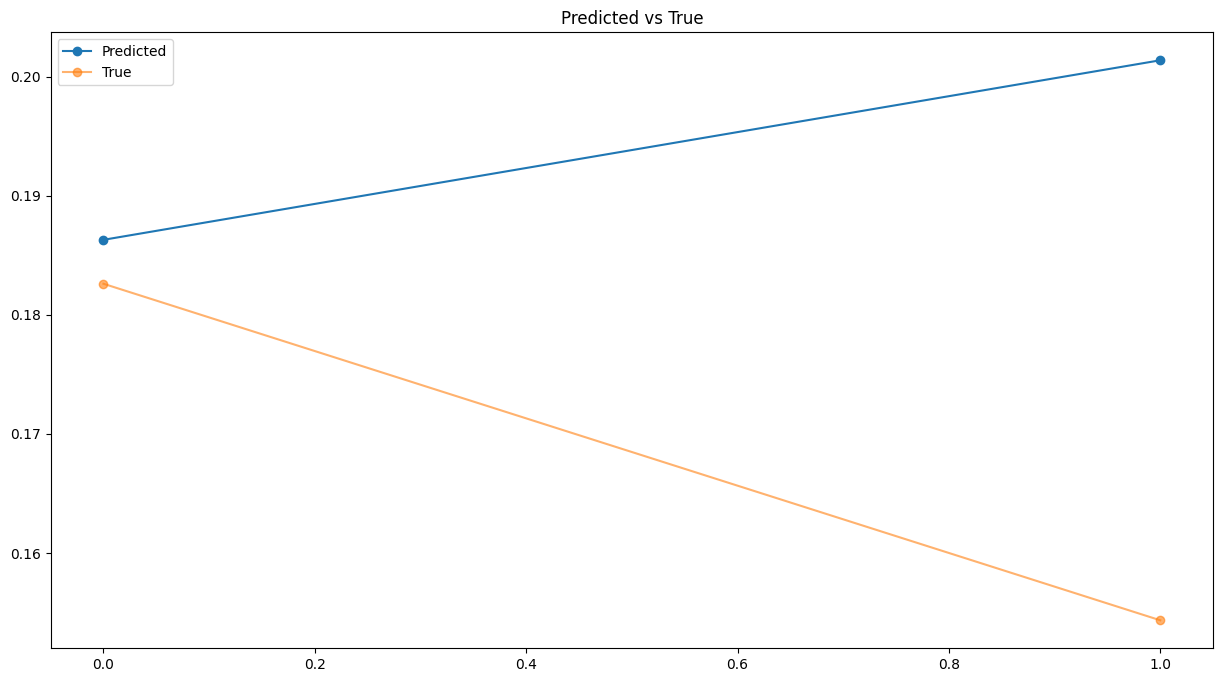

{'mae': 0.025358375971731933,
 'mse': 0.03335584110417091,
 'rmse': 0.0011126121357666978}

In [75]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [76]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             125.696915               124.0
1             132.632797               111.0

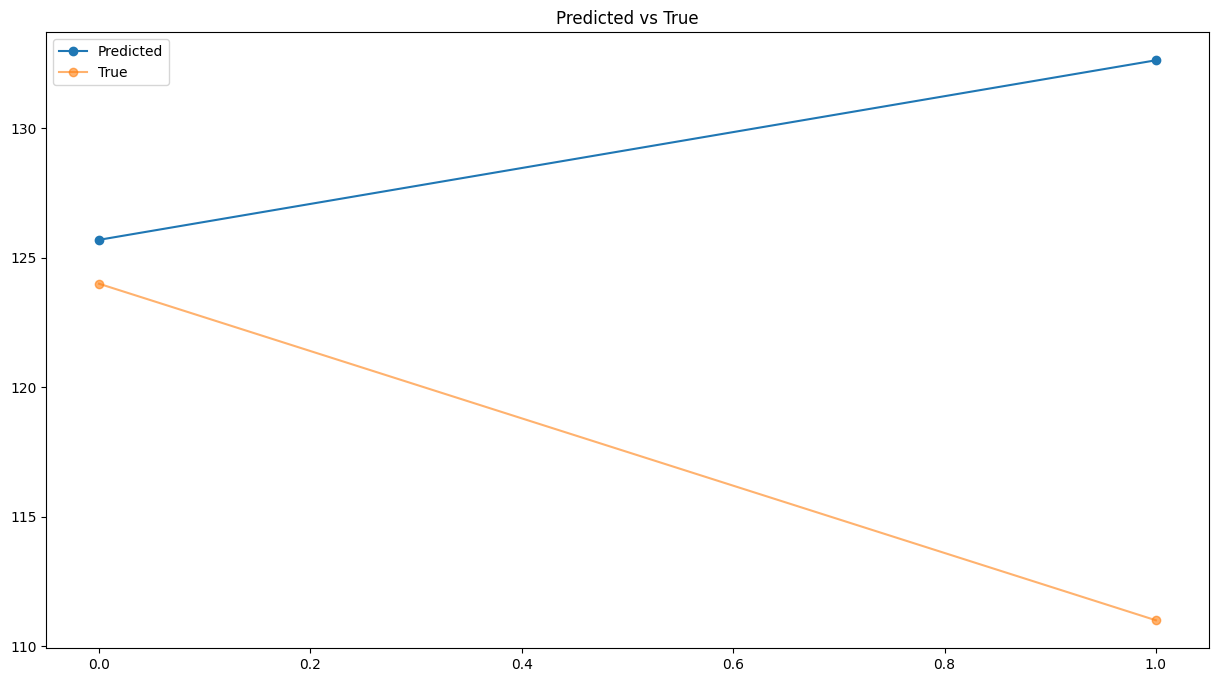

{'mae': 11.66485595703125,
 'mse': 15.343686582537497,
 'rmse': 235.42871794314124}

In [77]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM con dropout

In [78]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_dropout.h5')

In [79]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [80]:
len(array_Ytest)

191

6/6 [==============================] - 0s 5ms/step


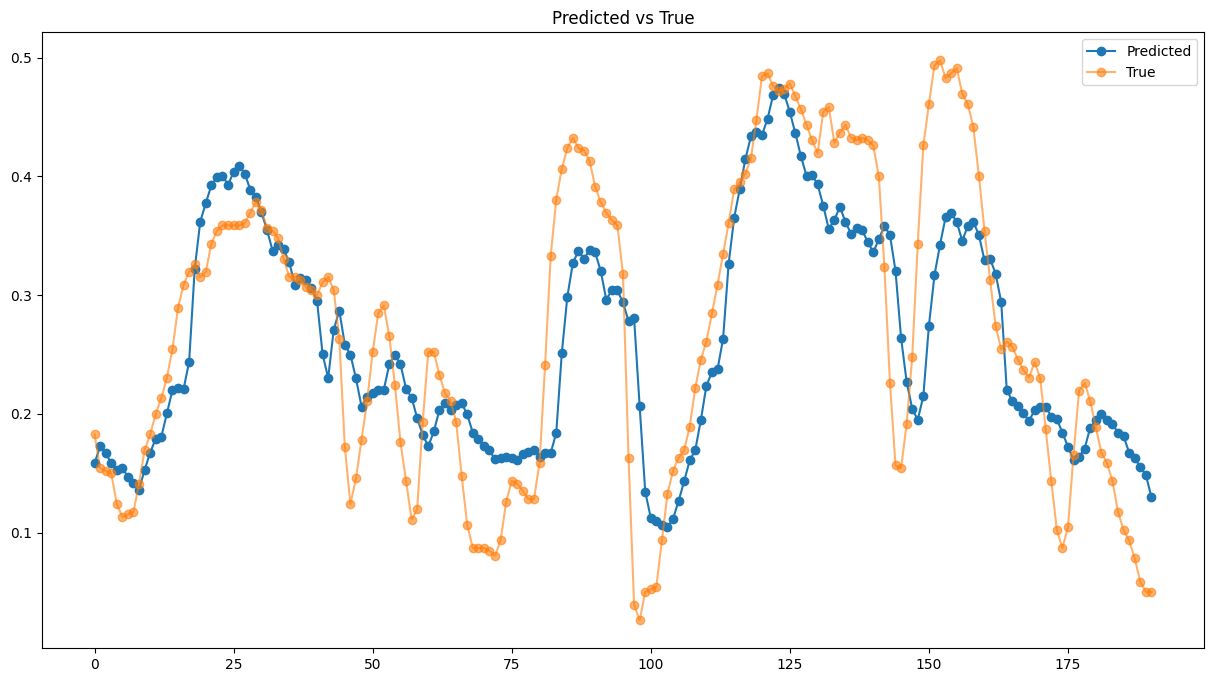

In [81]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [82]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.056543083365132314,
 'mse': 0.0718689170549548,
 'rmse': 0.005165141238651972}

In [83]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       112.781967
1       119.427330
2       116.780708
3       112.910591
4       110.115189
..             ...
186     116.983124
187     114.909286
188     111.366402
189     108.392494
190      99.807014

[191 rows x 1 columns]

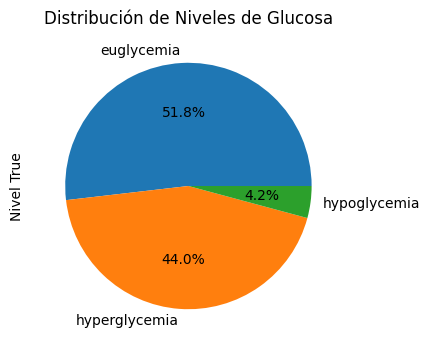

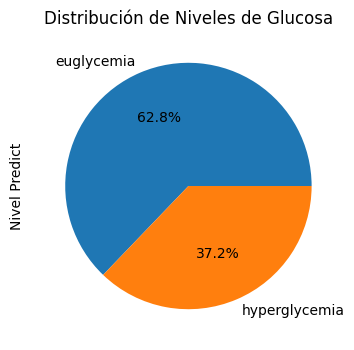

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             112.781967    euglycemia
1               111.0  euglycemia             119.427330    euglycemia
2               110.0  euglycemia             116.780708    euglycemia
3               109.0  euglycemia             112.910591    euglycemia
4                97.0  euglycemia             110.115189    euglycemia

In [84]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


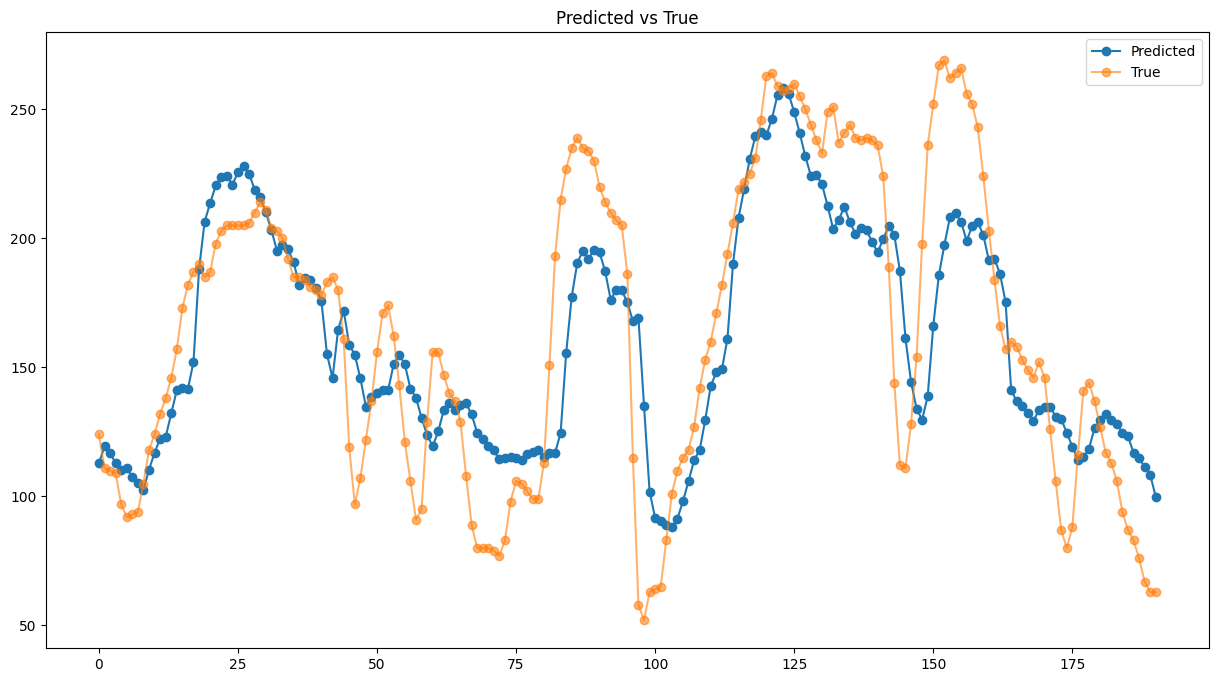

{'mae': 26.009817752538552,
 'mse': 33.059701260433734,
 'rmse': 1092.943847429124}

In [85]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [86]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [87]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  112.781967
2023-01-01 00:15:00   111.0  119.427330
2023-01-01 00:30:00   110.0  116.780708
2023-01-01 00:45:00   109.0  112.910591
2023-01-01 01:00:00    97.0  110.115189
...                     ...         ...
2023-01-02 22:30:00    83.0  116.983124
2023-01-02 22:45:00    76.0  114.909286
2023-01-02 23:00:00    67.0  111.366402
2023-01-02 23:15:00    63.0  108.392494
2023-01-02 23:30:00    63.0   99.807014

[191 rows x 2 columns]

AP, BE, EP: (0.8842105263157894, 0.06315789473684211, 0.05263157894736842)


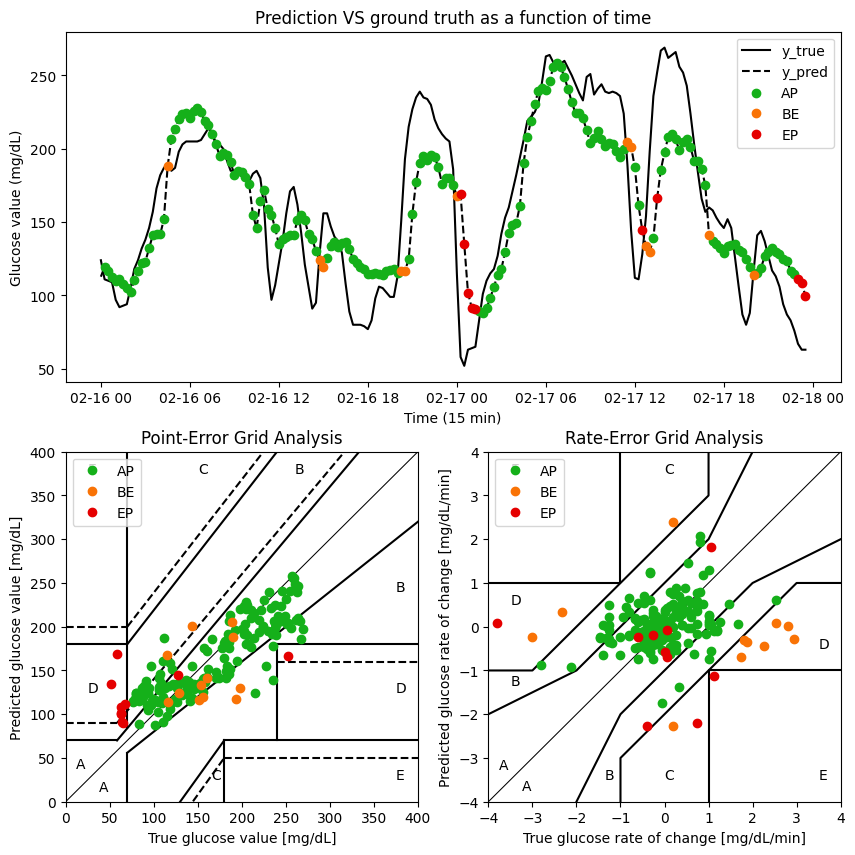

In [88]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [89]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-16 00:00:00   124.0  112.781967       NaN       NaN    NaN   NaN   
1   2023-02-16 00:15:00   111.0  119.427330 -0.866667  0.443024     AP     A   
2   2023-02-16 00:30:00   110.0  116.780708 -0.066667 -0.176441     AP     A   
3   2023-02-16 00:45:00   109.0  112.910591 -0.066667 -0.258008     AP     A   
4   2023-02-16 01:00:00    97.0  110.115189 -0.800000 -0.186360     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-17 22:30:00    83.0  116.983124 -0.266667 -0.423313     AP     B   
187 2023-02-17 22:45:00    76.0  114.909286 -0.466667 -0.138256     AP     B   
188 2023-02-17 23:00:00    67.0  111.366402 -0.600000 -0.236192     EP     D   
189 2023-02-17 23:15:00    63.0  108.392494 -0.266667 -0.198261     EP     D   
190 2023-02-17 23:30:00    63.0   99.807014  0.000000 -0.572365     EP     D   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [90]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [91]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 28ms/step


Glucose level Predict  Glucose level True
0               0.158222            0.182609
1               0.172668            0.154348

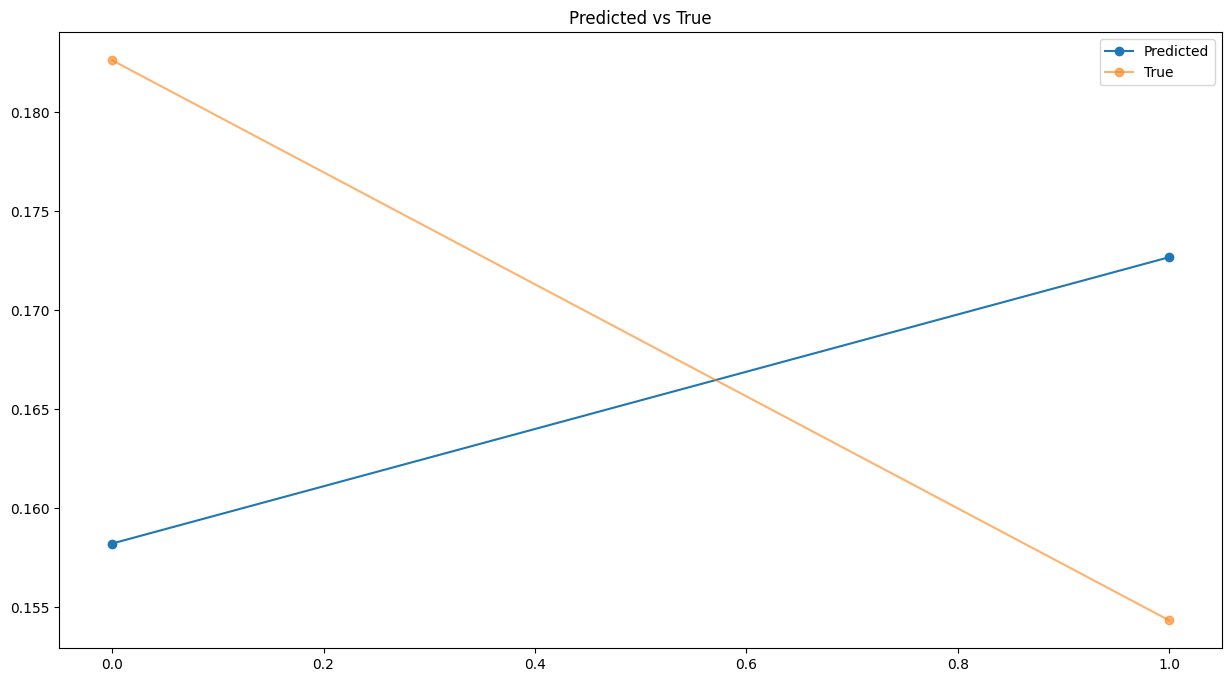

{'mae': 0.021353653462036798,
 'mse': 0.021568029842443864,
 'rmse': 0.00046517991128454904}

In [92]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [93]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0              112.78196               124.0
1              119.42733               111.0

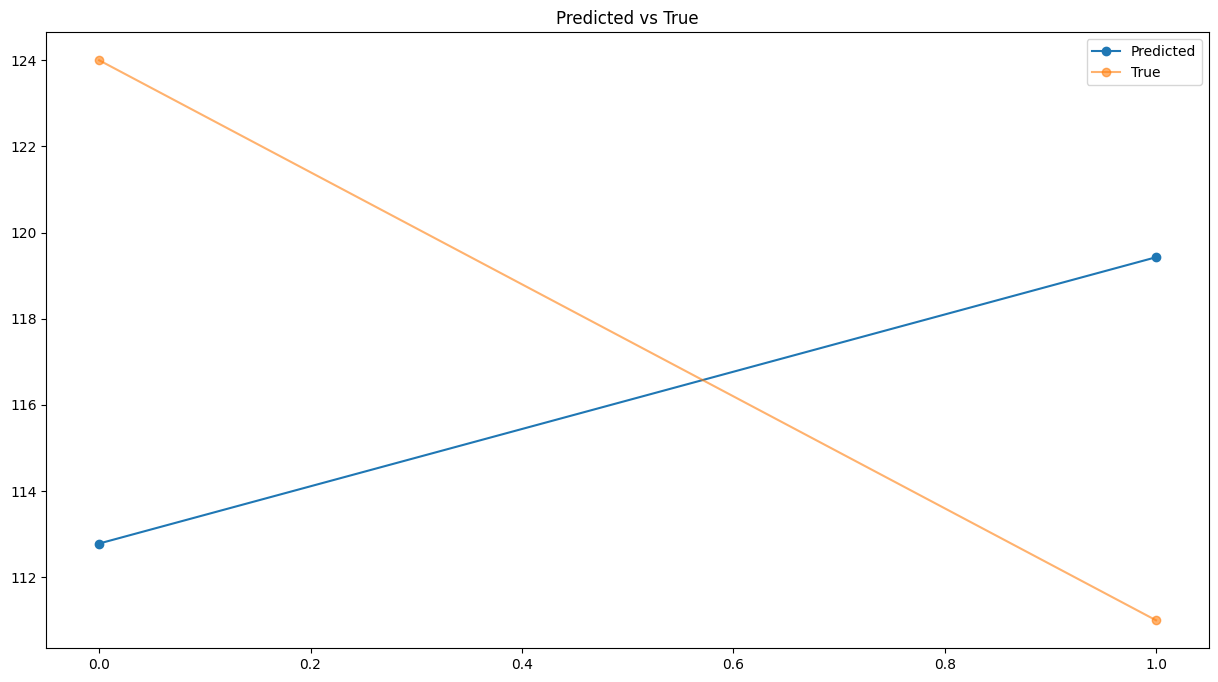

{'mae': 9.822685241699219, 'mse': 9.921298380773573, 'rmse': 98.43216156034032}

In [94]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM sin dropout

In [95]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_NO_dropout.h5')

In [96]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [97]:
len(array_Ytest)

191

6/6 [==============================] - 1s 7ms/step


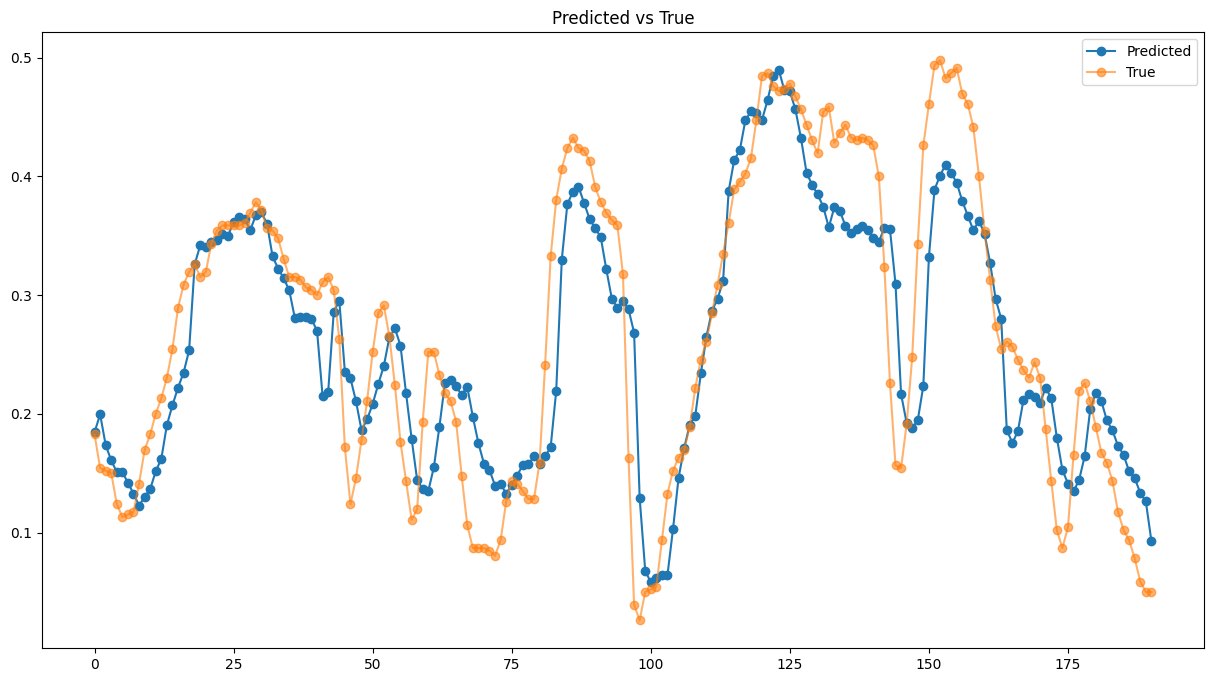

In [98]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [99]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04771813633259163,
 'mse': 0.06161274147473942,
 'rmse': 0.0037961299120330754}

In [100]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       124.893822
1       131.793442
2       119.889336
3       113.919907
4       109.417542
..             ...
186     109.662498
187     107.072647
188     101.341042
189      98.073158
190      82.738190

[191 rows x 1 columns]

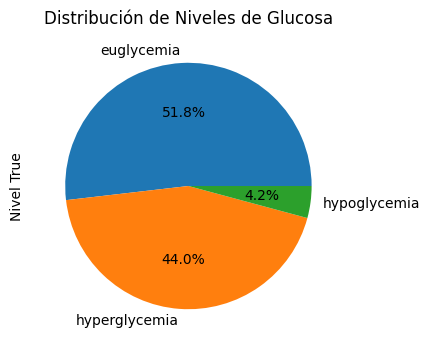

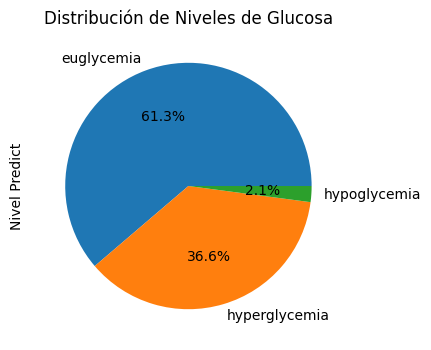

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             124.893822    euglycemia
1               111.0  euglycemia             131.793442    euglycemia
2               110.0  euglycemia             119.889336    euglycemia
3               109.0  euglycemia             113.919907    euglycemia
4                97.0  euglycemia             109.417542    euglycemia

In [101]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


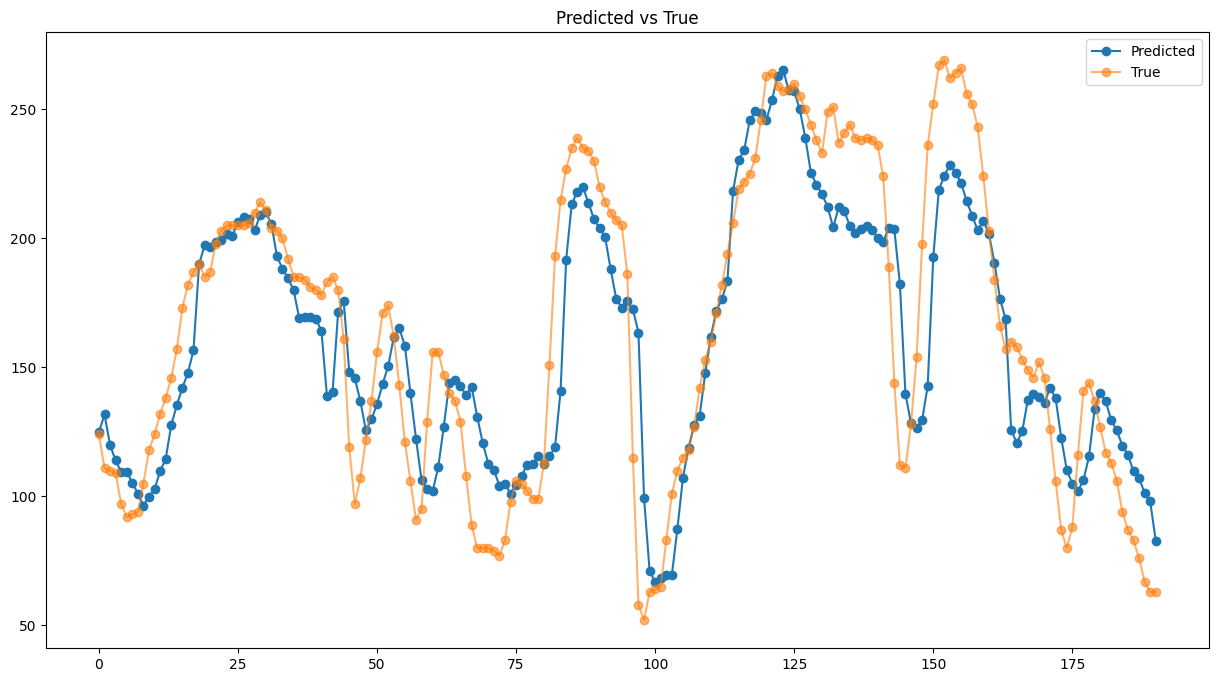

{'mae': 21.950341868775052,
 'mse': 28.341860738930237,
 'rmse': 803.2610701449153}

In [102]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [103]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [104]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  124.893822
2023-01-01 00:15:00   111.0  131.793442
2023-01-01 00:30:00   110.0  119.889336
2023-01-01 00:45:00   109.0  113.919907
2023-01-01 01:00:00    97.0  109.417542
...                     ...         ...
2023-01-02 22:30:00    83.0  109.662498
2023-01-02 22:45:00    76.0  107.072647
2023-01-02 23:00:00    67.0  101.341042
2023-01-02 23:15:00    63.0   98.073158
2023-01-02 23:30:00    63.0   82.738190

[191 rows x 2 columns]

AP, BE, EP: (0.8947368421052632, 0.07894736842105263, 0.02631578947368421)


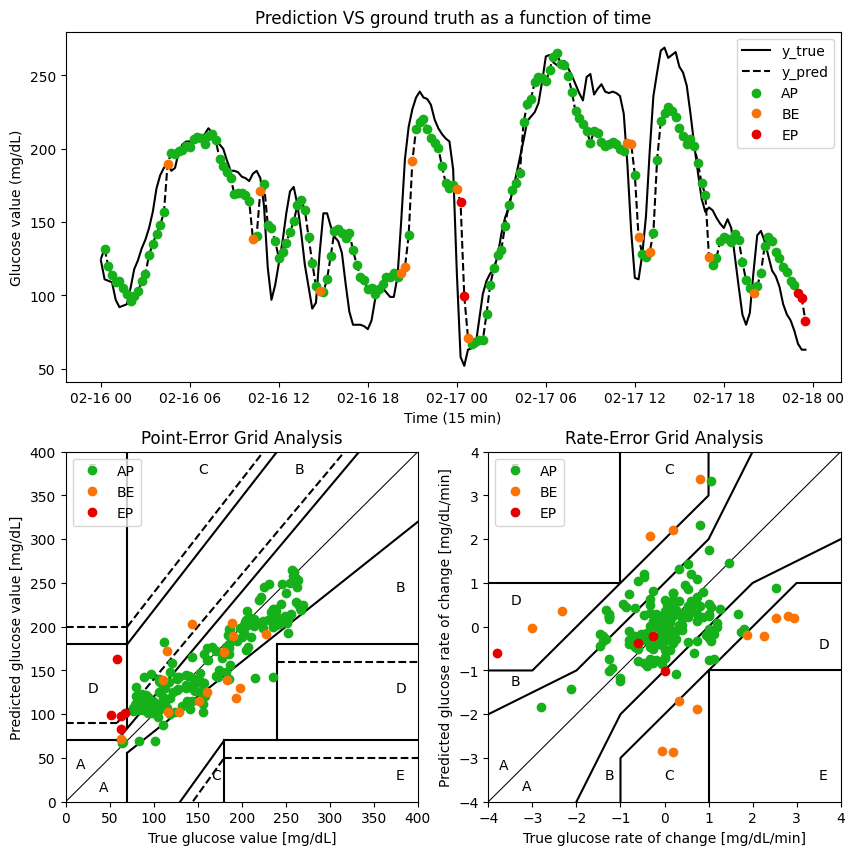

In [105]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [106]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-16 00:00:00   124.0  124.893822       NaN       NaN    NaN   NaN   
1   2023-02-16 00:15:00   111.0  131.793442 -0.866667  0.459975     AP     A   
2   2023-02-16 00:30:00   110.0  119.889336 -0.066667 -0.793607     AP     A   
3   2023-02-16 00:45:00   109.0  113.919907 -0.066667 -0.397962     AP     A   
4   2023-02-16 01:00:00    97.0  109.417542 -0.800000 -0.300158     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-17 22:30:00    83.0  109.662498 -0.266667 -0.432255     AP     B   
187 2023-02-17 22:45:00    76.0  107.072647 -0.466667 -0.172657     AP     B   
188 2023-02-17 23:00:00    67.0  101.341042 -0.600000 -0.382107     EP     D   
189 2023-02-17 23:15:00    63.0   98.073158 -0.266667 -0.217859     EP     D   
190 2023-02-17 23:30:00    63.0   82.738190  0.000000 -1.022331     EP     D   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     B  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [107]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [108]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 40ms/step


Glucose level Predict  Glucose level True
0               0.184552            0.182609
1               0.199551            0.154348

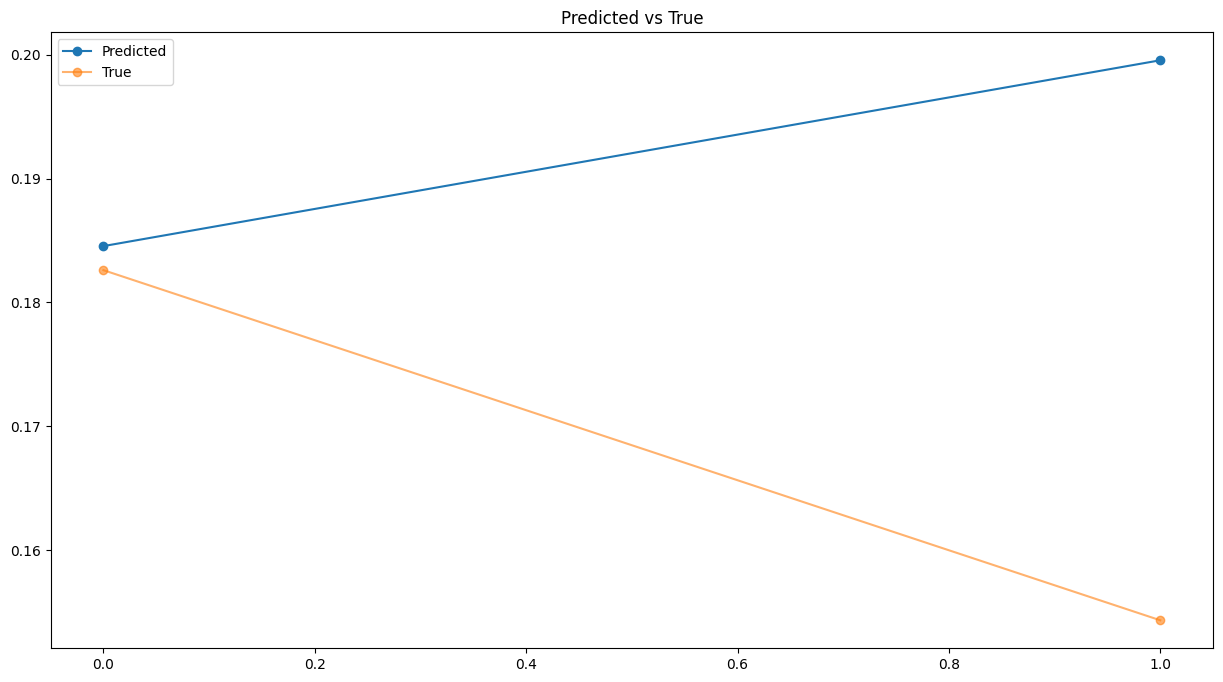

{'mae': 0.023573134904322418,
 'mse': 0.0319929685870971,
 'rmse': 0.0010235500390149816}

In [109]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [110]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             124.893837               124.0
1             131.793442               111.0

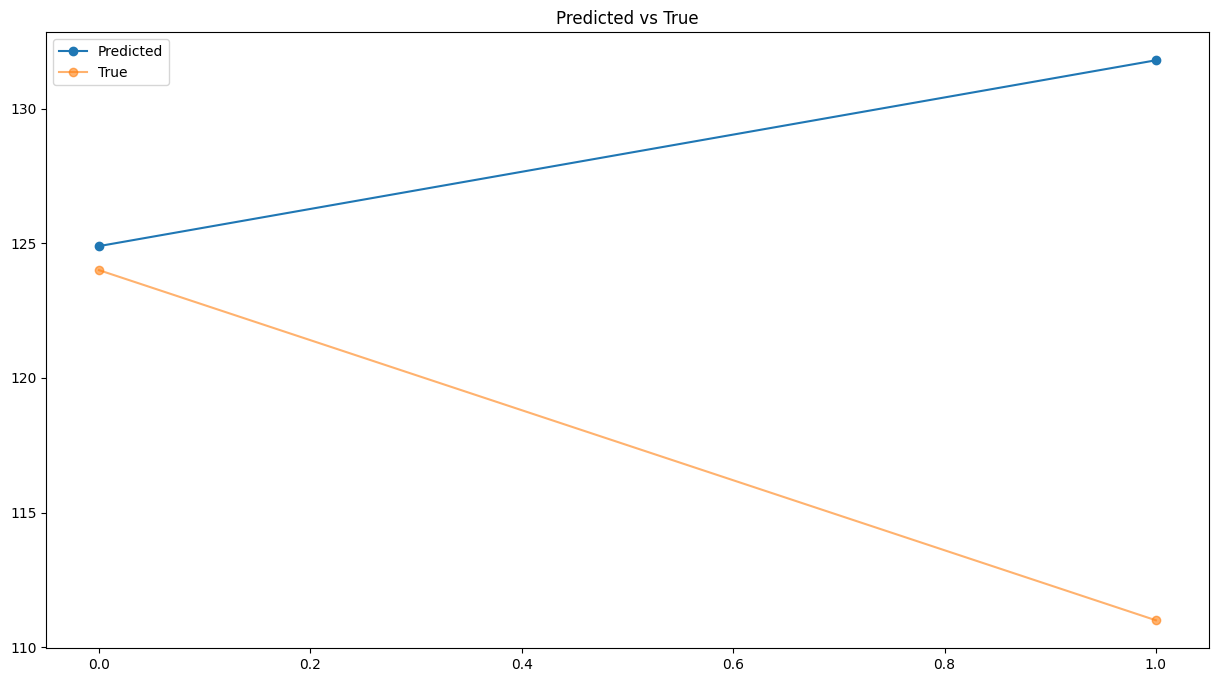

{'mae': 10.843639373779297,
 'mse': 14.716761961837515,
 'rmse': 216.5830826413876}

In [111]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)